In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath

In [ ]:
class Actor(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, output_size)

        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear2(F.relu(self.linear1(state))))
        x = torch.tanh(self.linear3(x))
        return x



class Critic(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, output_size)


    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        #print(state.shape)
        #print(action.shape)
        x = torch.cat([state, action], dim = 1)
        x = F.relu(self.linear2(F.relu(self.linear1(x))))
        x = torch.tanh(self.linear3(x))

        return x

In [ ]:
num_states = 50
hidden_size_1 = 300
hidden_size_2 = 200
num_actions = 50+1
actor_eval = Actor(num_states, hidden_size_1, hidden_size_2, num_actions)
actor_target = Actor(num_states, hidden_size_1, hidden_size_2, num_actions)
critic_eval = Critic(num_states + num_actions, hidden_size_1, hidden_size_2, num_actions)
critic_target = Critic(num_states + num_actions, hidden_size_1, hidden_size_2, num_actions)

# We initialize the target networks as copies of the original networks
for target_param, param in zip(actor_target.parameters(), actor_eval.parameters()):
    target_param.data.copy_(param.data)
for target_param, param in zip(critic_target.parameters(), critic_eval.parameters()):
    target_param.data.copy_(param.data)

In [ ]:
import random
from collections import deque

class Replay:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state):
        experience = (state, action, np.array([reward]), next_state)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state = experience
            #print(state.shape)
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            #done_batch.append(done)
        #print(state_batch)
        #print(torch.FloatTensor(state_batch))
        
        return state_batch, action_batch, reward_batch, next_state_batch

    def __len__(self):
        return len(self.buffer)

In [ ]:
"""
Taken from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
"""
class OUNoise(object):
    def __init__(self, action_dim, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.low          = 0
        self.high         = 2*np.pi
        self.action_dim = action_dim
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0): 
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [ ]:

import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn


class DDPGagent:
    def __init__(self, num_states, actor_learning_rate=1e-4, critic_learning_rate=1e-3, disc_fact=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = num_states
        self.num_actions = num_states + 1
        self.disc_fact = disc_fact
        self.tau = tau

        # Networks
        self.actor_eval = Actor(num_states+1, hidden_size_1, hidden_size_2, num_states)
        self.actor_target = Actor(num_states+1, hidden_size_1, hidden_size_2, num_states)
        self.critic_eval = Critic(2*num_states+1, hidden_size_1, hidden_size_2, 1)
        self.critic_target = Critic(2*num_states+1, hidden_size_1, hidden_size_2, 1)

        for target_param, param in zip(self.actor_target.parameters(), self.actor_eval.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic_eval.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Replay(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor_eval.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic_eval.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        #print(state.shape)
        action = self.actor_eval.forward(state)
        #print(action.shape)
        action = action.detach().numpy()[0,0]
  
        return action.reshape((1, self.num_states))
    
    def update(self, batch_size):
        states, actions, rewards, next_states = self.memory.sample(batch_size)
        #print(states)
        #print(states[0])
        states = torch.FloatTensor(states)
        #states = states.unsqueeze(1)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        #print(states.shape)
        #print(actions.shape)
        # Critic loss        
        Qvals = self.critic_eval.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards.clone()
        for i in range(len(rewards)):
          Qprime[i] = rewards[i] + self.disc_fact* next_Q[i]
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic_eval.forward(states, self.actor_eval.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor_eval.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic_eval.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

In [ ]:
#M is the number of transmitter's antennas
#N is the number of receiver' antennas
#dist is the distance between the transmitter and the receiver
#pl is path-loss exponent
#Kdb is the Rician factor in dB

def Rician_Fading_Channels(M,N,dist,pl, Kdb):  
    K = 10**(Kdb/10) #dB to mW
    mu = np.sqrt( K/((K+1))) #direct path
    s = np.sqrt( 1/(2*(K+1))) #scattered paths
    Hw = mu + s*(np.random.randn(M,N)+1j*np.random.randn(M,N)) #Rician channel
    H = np.sqrt(1/(dist**pl))*Hw  #Rician channel with pathloss  
    return H

In [ ]:
import math
def rayleigh_fading(loss_exp, M, d):
  path_loss = -30 + 10*loss_exp*math.log10(d/1)
  z = []
  for i in range(500):
    vec = np.sqrt(path_loss)*np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(M, 2)).view(np.complex128) 
    z.append(vec.T)
  return np.mean(z, 0).reshape((M,1))

In [ ]:
1/np.inf

0.0

In [ ]:
def aN(N, theta, d):
  a = []
  for i in range(N):
    a.append(cmath.exp(-1j*2*np.pi*i*theta/2))
  return np.reshape(np.matrix(a), (1, N))


In [ ]:

def rician_fading_G(loss_exp, K, Nx, Ny, M,theta_AOAh, theta_AOAv, theta_AODb, d):
  path_loss = -30 + 10*loss_exp*math.log10(d)
  f1 = np.sqrt(1/(1+(1/K)))
  f2 = np.sqrt(1/(K+1))
  aNx = aN(Nx, np.sin(theta_AOAh), d).getH()
  #print(aNx)
  aNy = aN(Ny, np.sin(theta_AOAv), d).getH()
  #print(aNy)
  aN_= aN(M, np.sin(theta_AODb), d)
  #print(aN_)
  bar = np.matmul(np.kron(aNx, aNy), aN_)
  #print(bar)
  z = []
  for i in range(500):
    vec = []
    for i in range(Nx*Ny):
      vec.append(np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(M, 2)).view(np.complex128) )
    curl = np.array(vec).squeeze(2)
    z.append(curl)
  vecs = np.sqrt(path_loss)*(f1*bar + f2*np.mean(z,0))
  return vecs

In [ ]:
G_ = np.matrix(rician_fading_G(2, np.inf, 10 ,5, 10,np.pi/3, np.pi/3, np.pi/6, d))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
d

20.0

In [ ]:
np.sqrt(-30 + 10*2*math.log10(35))

7.802650888448458

In [ ]:
hr  = np.matrix(rician_fading_h(2.8, 0, 5, 3, np.pi/6, np.pi/6, 48))
G = np.matrix(rician_fading_G(2.8, np.inf, 5, 3, 8,np.pi/3,  np.pi/3, np.pi/6, 51))
hd = np.matrix(rayleigh_fading(5, 8, 48))
import random
angles = []
num_states = 15
an = np.linspace(0, 1, 15)
for i in an:
  angles.append(2*np.pi*i)
angles_ = []
for i in range(len(angles)):
  angles_.append(cmath.exp(1j*angles[i]))
np.array(angles_)
shifts = np.diag(angles_)
sum = np.matmul(np.matmul(hr.getH(), shifts), G) + hd.getH()

In [ ]:
def rician_fading_h(loss_exp, K, Nx, Ny, theta_AODh, theta_AODv, d):
  path_loss = -30 + 10*loss_exp*math.log10(d)
  f1 = np.sqrt(K/(K+1))
  f2 = np.sqrt(1/(K+1))
  phi = np.cos(theta_AODv) * np.sin(theta_AODh)
  a1 = aN(Ny, np.sin(theta_AODv),d).getH()
  a2 = aN(Nx, phi, d).getH()
  bar = np.kron(a1, a2)
  z = []
  for i in range(500):
    curl = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(Nx*Ny, 2)).view(np.complex128)
    z.append(curl)
  vecs = np.sqrt(path_loss)*(f1*bar + f2*np.mean(z,0))
  return vecs

In [ ]:

def Phase_shifts(angles, num_states, hr_, G_, hd_,  Pmax, sigma):
  angles_ = []
  #print(angles[2])
  for i in range(len(angles)):
    angles_.append(cmath.exp(1j*angles[i]))
  shifts = np.diag(angles_)
  return angles, shifts


In [ ]:
angles, shifts = Phase_shifts(angles, 5*3, hr, G, hd, 5, 80)

In [ ]:
angles

[0.0,
 0.4487989505128276,
 0.8975979010256552,
 1.3463968515384828,
 1.7951958020513104,
 2.2439947525641375,
 2.6927937030769655,
 3.141592653589793,
 3.5903916041026207,
 4.039190554615448,
 4.487989505128275,
 4.9367884556411035,
 5.385587406153931,
 5.834386356666758,
 6.283185307179586]

In [ ]:


b = np.sqrt(5)* sum.getH() / (np.matmul( sum, sum.getH()).item())**(1/2)
snr = (1/80)* np.abs(np.matmul(sum, b))**2
snr = snr.item()
snr

3.8646524554494777

In [ ]:
def SNR(hr, shifts, G, hd,  Pmax, sigma):
  #print(hr.shape)
  #print(G.shape)
  #print(shifts.shape)
  #print(hd.shape)
  sum = np.matmul(np.matmul(hr.getH(), shifts), G) + hd.getH()
  b = np.sqrt(Pmax)* sum.getH() / np.sqrt(np.matmul(sum, sum.getH()).item())
  snr = (1/sigma)* np.abs(np.matmul(sum, b))**2
  return snr.item()

In [ ]:
from torch.autograd import Variable
agent = DDPGagent(5*3, actor_learning_rate=1e-3, critic_learning_rate=1e-3, disc_fact=0.95, tau= 0.005, max_memory_size=50000)
angles.append(snr)
state = np.matrix(angles)
action = agent.get_action(state)

In [ ]:
state

matrix([[ 0.        ,  0.44879895,  0.8975979 ,  1.34639685,  1.7951958 ,
          2.24399475,  2.6927937 ,  3.14159265,  3.5903916 ,  4.03919055,
          4.48798951,  4.93678846,  5.38558741,  5.83438636,  6.28318531,
         55.72660706]])

In [ ]:
action

array([[-0.69617873,  0.89243233, -0.9474367 ,  0.6710865 , -0.6153545 ,
         0.19047476, -0.73005676, -0.7731029 ,  0.38900527,  0.8313227 ,
         0.20968774,  0.961798  ,  0.7920115 , -0.630361  ,  0.9530088 ]],
      dtype=float32)

In [ ]:
noise = OUNoise(5*3)
noise.reset()
noise.get_action(action)[0]

array([0.        , 1.43575951, 0.        , 0.81186771, 0.        ,
       0.        , 0.        , 0.        , 0.15577834, 0.48152421,
       0.27477716, 0.89641577, 1.34822109, 0.        , 1.35662631])

In [ ]:
action

array([[-0.69617873,  0.89243233, -0.9474367 ,  0.6710865 , -0.6153545 ,
         0.19047476, -0.73005676, -0.7731029 ,  0.38900527,  0.8313227 ,
         0.20968774,  0.961798  ,  0.7920115 , -0.630361  ,  0.9530088 ]],
      dtype=float32)

In [ ]:
a, b=Phase_shifts(action, 5*3,hr, G, hd, 5, 80 )
a.shape

TypeError: ignored

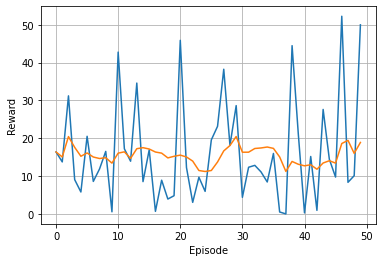

In [ ]:

import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Nx = 10
Ny = 5
M = 10
T = 1000
Pmax = 5
d = 48
num_states = Nx*Ny
agent = DDPGagent(Nx*Ny, actor_learning_rate=1e-3, critic_learning_rate=1e-3, disc_fact=0.95, tau= 0.005, max_memory_size=50000)
batch_size = 16
rewards = []
avg_rewards = []
noise = OUNoise(Nx*Ny)

for episode in range(50):
    hr_ = np.matrix(rician_fading_h(2.8, 0, Nx, Ny, np.pi/6, np.pi/6, d))
    G_ = np.matrix(rician_fading_G(2, np.inf, Nx ,Ny, M,np.pi/3, 5*np.pi/3, np.pi/6, d))
    hd_ = np.matrix(rayleigh_fading(2.8, M, d))
    angles = []
    for i in range(Nx*Ny):
      angles.append(2*np.pi*random.random())
    angles, shifts = Phase_shifts(angles, Nx*Ny, hr_, G_, hd_, Pmax, 80)
    #print(angles)
    noise.reset()
    snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80)
    #print(snr)
    angles.append(snr)
    state = np.matrix(angles)
    #print(np.array(state)[0])
    #noise = np.random.normal(loc=0, scale=np.sqrt(0.05), size=(Nx*Ny, 2)).view(np.complex128)
    episode_reward = 0
    
    for step in range(T):
        action = agent.get_action(state)
        action__ = noise.get_action(action)
        #print(action[0])
        action_ = action__[0].tolist()
        #print(action__)
        new_angles, shifts = Phase_shifts(action_, Nx*Ny, hr, G, hd, Pmax, 80)
        snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80)
        #print(snr)
        new_angles.append(snr)
        new_state = np.matrix(angles)
        #print(new_state)
        reward = new_state[:,-1].item()
        agent.memory.push(np.array(state)[0], action__[0], reward, np.array(new_state)[0])
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward
    rewards.append(episode_reward/T)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()

In [ ]:
rewards

[16.387041277117078,
 13.763174411762655,
 31.211661335611947,
 9.080574202510688,
 5.815654626066136,
 20.528986335450753,
 8.60852156619329,
 11.894772753363332,
 16.541065929550438,
 0.5792265312289093,
 42.77121233735688,
 17.22326813679648,
 13.944596072985908,
 34.59080805033657,
 8.555800202094105,
 16.962990739122542,
 0.7032121436516651,
 8.930973802300485,
 3.9548434476272645,
 4.835003934647467,
 45.883665509829996,
 12.27661978190432,
 3.0772496593417697,
 9.715150586009209,
 5.980755743773735,
 19.58686347890003,
 23.162845484783784,
 38.24841849225466,
 18.139639279307126,
 28.635774186011144,
 4.407339909895603,
 12.354168919712377,
 12.85058807817757,
 11.118022888129252,
 8.461767580747443,
 15.997563559225913,
 0.5305229577639508,
 0.024160510466554316,
 44.474190821099945,
 21.188429236375665,
 0.2916654993457304,
 15.194349718714877,
 0.965604208180798,
 27.622112404976225,
 14.449537137759886,
 9.75635709824506,
 52.245547813676666,
 8.371950199164605,
 10.12605984

In [ ]:

hr_ = np.matrix(rician_fading_h(2.8, 0, Nx, Ny, 5*np.pi/3, 2*np.pi/6, d))
G_ = np.matrix(rician_fading_G(2, np.inf, Nx ,Ny, M,7*np.pi/4, 5*np.pi/6, np.pi/4, d))
hd_ = np.matrix(rayleigh_fading(2.8, M, d))
angles = []
an = np.linspace(0, 1, 50)
for i in an:
  angles.append(2*np.pi*random.random())
angles, shifts = Phase_shifts(angles, Nx*Ny, hr_, G_, hd_, Pmax, 80)
snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80)
snr

2.955443856691618

In [ ]:
an

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [ ]:
hd_

matrix([[ 0.05191088-0.03203446j],
        [ 0.11935066-0.06860345j],
        [-0.12063634-0.20937766j],
        [ 0.14915376-0.19458881j],
        [ 0.14211592+0.03346198j],
        [ 0.01120648-0.05810341j],
        [ 0.11603288-0.04510178j],
        [ 0.13203587-0.01285911j],
        [-0.0068701 +0.02026694j],
        [ 0.13506119+0.04766442j]])

In [ ]:
state

matrix([[2.35096726, 4.01078782, 3.74522033, 0.49852548, 0.72148644,
         4.75488745, 5.65200511, 3.68765496, 1.84274254, 0.7426626 ,
         5.16411197, 2.86629497, 2.59703958, 2.04753304, 1.05241827,
         3.28853497, 0.26423602, 0.5755661 , 0.748011  , 2.67294295,
         2.35943591, 0.30888564, 3.26547334, 0.96895927, 4.88610469,
         4.9614098 , 4.43974428, 0.94409568, 3.07616209, 5.6119743 ,
         2.67595051, 1.43226666, 4.89815079, 1.18750519, 4.65837174,
         0.49705965, 2.14881836, 5.31366735, 1.74556343, 1.23565433,
         4.06439669, 5.79895222, 5.289556  , 2.4339274 , 4.31456321,
         2.74242379, 5.32568953, 5.40757807, 6.11469505, 1.10896554,
         7.43234118]])

In [ ]:
hd

matrix([[ 0.05614435+0.44808339j],
        [-0.01265625-0.29550421j],
        [ 0.14940956-0.16426681j],
        [-0.00454192+0.42408331j],
        [-0.03003696-0.14686732j],
        [ 0.21242496-0.13268478j],
        [-0.1267332 +0.08644797j],
        [-0.5589931 -0.11555929j]])

In [ ]:
rewards

[7.618076549455738,
 0.06909483079122401,
 1.5058367663158936,
 4.724692601663872,
 0.9451232581839198,
 4.27962961938225,
 2.4287520878635407,
 9.292429217755652,
 3.0068524364401217,
 4.715116119907255,
 6.350804313100526,
 0.699243602472383,
 9.292148847986779,
 1.2104724888624017,
 0.3334685883171504,
 0.2736735874012981,
 11.703087209377648,
 0.10521210541361282,
 0.5894983896044906,
 1.6013181554161975,
 11.26640217536441,
 0.21602021176574612,
 5.889068131426938,
 0.5804350959372213,
 8.930254725817377,
 0.413450687529476,
 4.053475070977693,
 0.049104222581320266,
 1.2634704315367766,
 0.9005910393179056,
 11.278035785086114,
 16.4700698142602,
 2.5811705102519658,
 1.4000231272971009,
 2.5124429136880737,
 14.32553336459399,
 1.7761244390852164,
 2.3248560339038824,
 0.4035524171782016,
 2.933316789304043,
 1.45595763630377,
 1.4791701451395007,
 6.294037283721011,
 2.183430224574913,
 0.44741342101320947,
 5.9584074756121685,
 3.9235421007768965,
 8.638955239896001,
 3.571586

In [ ]:
def IRS_problem(d):
  Nx = 10
  Ny = 5
  M = 10
  T = 1000
  Pmax = 5 
  num_states = Nx*Ny
  agent = DDPGagent(Nx*Ny, actor_learning_rate=1e-3, critic_learning_rate=1e-3, disc_fact=0.95, tau= 0.005, max_memory_size=50000)
  batch_size = 16
  rewards = []
  avg_rewards = []

  for episode in range(50):
    hr_ = np.matrix(rician_fading_h(2.8, 0, Nx, Ny, np.pi/6, np.pi/6, d))
    G_ = np.matrix(rician_fading_G(2, np.inf, Nx ,Ny, M,np.pi/3, 5*np.pi/3, np.pi/6, d))
    hd_ = np.matrix(rayleigh_fading(2.8, M, d))
    angles = []
    for i in range(Nx*Ny):
      angles.append(2*np.pi*random.random())
    angles, shifts = Phase_shifts(angles, Nx*Ny, hr_, G_, hd_, Pmax, 80)
    snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80)
    #print(snr)
    angles.append(snr)
    state = np.matrix(angles)
    #print(np.array(state)[0])
    noise = np.random.normal(loc=0, scale=np.sqrt(0.05), size=(Nx*Ny, 2)).view(np.complex128)
    episode_reward = 0
    
    for step in range(T):
      action = agent.get_action(state)
      noise = noise.reshape(action.shape)
      action = action + noise
      #print(action[0])
      action_ = action[0].tolist()
      new_angles, shifts = Phase_shifts(action_, Nx*Ny, hr_, G_, hd_, Pmax, 80)
      snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80)
      new_angles.append(snr)
      new_state = np.matrix(angles)
      #print(new_state)
      reward = new_state[:,-1].item()
      agent.memory.push(np.array(state)[0], action[0], reward, np.array(new_state)[0])
      if len(agent.memory) > batch_size:
        agent.update(batch_size)        
      state = new_state
      episode_reward += reward
    rewards.append(episode_reward/T)
    avg_rewards.append(np.mean(rewards[-10:]))
  return np.mean(rewards)


In [ ]:
angles

[4.12454537601207,
 2.5010908586490013,
 1.6614064974812828,
 0.07401900461802405,
 0.21791122790050357,
 2.089866983163486,
 4.568551171741723,
 3.0578457448647867,
 1.2625973739904597,
 5.608621790332854,
 0.914026581335399,
 4.570175239133554,
 4.15736139881632,
 3.182933733290785,
 1.745564169362436,
 4.9787770889564,
 4.276077943224722,
 4.440028047301033,
 3.3439826167099613,
 0.3632960490664434,
 1.4064926814386218,
 0.7074508389435534,
 4.9286431869537255,
 4.058159349604223,
 5.113518233898287,
 2.3836270521305245,
 1.5299954330313426,
 5.015611462882546,
 1.2942993605456237,
 0.6466262654798092,
 2.1673834386090864,
 0.234676877263881,
 0.7993215393695646,
 3.44593700461839,
 5.706796573262027,
 3.383132082889001,
 5.850645953802782,
 0.31718482302492684,
 3.296562825873307,
 0.5912999190338697,
 2.043558429303741,
 6.279857773657252,
 2.3379557315470234,
 2.5501795954219753,
 5.407019318806661,
 4.158020747000575,
 4.398168719373125,
 2.2251676678478294,
 3.5577064783872703,

In [ ]:
d_ = np.linspace(35, 100, 8)
snr = []
for d in d_:
  rew = IRS_problem(d)
  snr.append(rew)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
angles = []
for i in range(Nx*Ny):
  angles.append(2*np.pi*random.random())
angles, shifts = Phase_shifts(angles, Nx*Ny, hr_, G_, hd_, Pmax, 80)
snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80).item()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


AttributeError: ignored

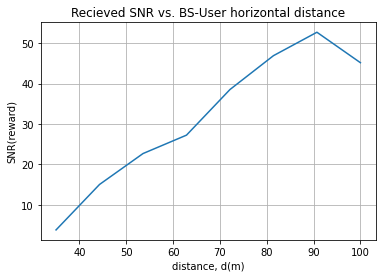

In [ ]:
plt.plot(d_, snr)
plt.xlabel("distance, d(m)")
plt.ylabel("SNR(reward)")
plt.title("Recieved SNR vs. BS-User horizontal distance")
plt.grid()
plt.show()

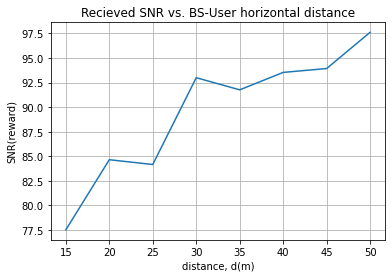

In [ ]:
plt.plot(d_, snr)
plt.xlabel("distance, d(m)")
plt.ylabel("SNR(reward)")
plt.title("Recieved SNR vs. BS-User horizontal distance")
plt.grid()
plt.show()

In [ ]:
def IRS_problem(Ny):
  Nx = 10
  M = 10
  T = 1000
  d = 90
  Pmax = 5 
  num_states = Nx*Ny
  #print(num_states)
  #print(Nx*Ny)
  agent = DDPGagent(Nx*Ny, actor_learning_rate=1e-3, critic_learning_rate=1e-3, disc_fact=0.95, tau= 0.005, max_memory_size=50000)
  batch_size = 16
  rewards = []
  avg_rewards = []

  for episode in range(50):
    hr_ = np.matrix(rician_fading_h(2.8, 0, Nx, Ny, np.pi/6, np.pi/6, d))
    G_ = np.matrix(rician_fading_G(2, np.inf, Nx ,Ny, M,np.pi/3, 5*np.pi/3, np.pi/6, d))
    hd_ = np.matrix(rayleigh_fading(2.8, M, d))
    angles = []
    for i in range(Nx*Ny):
      angles.append(2*np.pi*random.random())
    angles, shifts = Phase_shifts(angles, Nx*Ny, hr_, G_, hd_, Pmax, 80)
    snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80)
    #print(snr)
    angles.append(snr)
    state = np.matrix(angles)
    #print(np.array(state)[0])
    noise = np.random.normal(loc=0, scale=np.sqrt(0.05), size=(Nx*Ny, 2)).view(np.complex128)
    episode_reward = 0
    
    for step in range(T):
      action = agent.get_action(state)
      noise = noise.reshape(action.shape)
      action = action + noise
      #print(action[0])
      action_ = action[0].tolist()
      new_angles, shifts = Phase_shifts(action_, Nx*Ny, hr_, G_, hd_, Pmax, 80)
      snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80)
      new_angles.append(snr)
      new_state = np.matrix(angles)
      #print(new_state)
      reward = new_state[:,-1].item()
      agent.memory.push(np.array(state)[0], action[0], reward, np.array(new_state)[0])
      if len(agent.memory) > batch_size:
        agent.update(batch_size)        
      state = new_state
      episode_reward += reward
    rewards.append(episode_reward/T)
    avg_rewards.append(np.mean(rewards[-10:]))
  return np.mean(rewards)


In [ ]:
snr1 = snr

In [ ]:
N = [2, 3, 4, 5, 6, 7]
snr_ = []
for Ny in N:
  rew = IRS_problem(Ny)
  snr_.append(rew)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
for i in range(len(N)):
  N[i] = 10* N[i]

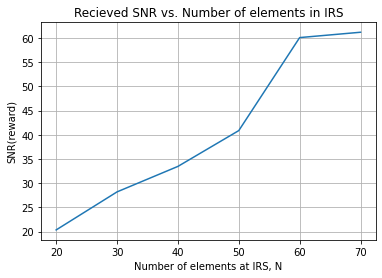

In [ ]:
plt.plot(N, snr_)
plt.xlabel("Number of elements at IRS, N")
plt.ylabel("SNR(reward)")
plt.title("Recieved SNR vs. Number of elements in IRS")
plt.grid()
plt.show()

In [ ]:
action = agent.get_action(np.matrix(angles))
action

array([[ 0.9999956 , -0.8653072 , -0.99963915,  1.        , -0.9999997 ,
        -0.9977284 ,  0.99999994, -0.9999959 , -1.        ,  0.9999976 ,
        -0.15700561,  0.9992666 , -0.9999982 , -0.9999989 ,  1.        ,
        -0.9999984 , -0.99999976, -1.        ,  0.99999696, -0.99999934,
        -0.99999994,  0.9999999 , -0.9999905 ,  0.9999983 , -0.99999714,
        -0.9999999 ,  0.9999968 ,  0.9999981 ,  0.9998087 , -0.99999994,
        -1.        , -1.        ,  0.9999995 , -1.        , -1.        ,
         0.9999944 ,  0.99999994,  0.99999994, -0.99999994, -0.9999995 ,
        -0.9999834 , -0.99999887,  0.99999994, -0.9999998 ,  0.9999798 ,
        -0.9991274 ,  0.9999999 , -0.9999965 ,  0.9999999 ,  0.9999979 ]],
      dtype=float32)

In [ ]:
action = action + np.random.normal(loc=0, scale=np.sqrt(0.05), size=(Nx*Ny, 2)).view(np.complex128)

In [ ]:
action_ = action[0].tolist()
new_angles, shifts = Phase_shifts(action_, Nx*Ny, hr, G, hd, Pmax, 80)

In [ ]:
snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80).item()

In [ ]:
np.matmul(sum, sum.getH())

matrix([[47129.23115183+0.j]])

In [ ]:
sum = np.matmul(np.matmul(hr_.getH(), shifts), G_) + hd_.getH()
b = np.sqrt(Pmax)* sum.getH() / np.matmul(sum, sum.getH()).item()


In [ ]:
hr_ = np.matrix(rician_fading_h(2.8, 10, Nx, Ny, 5*np.pi/3, 2*np.pi/6, d))
G_ = np.matrix(rician_fading_G(2, 10, Nx ,Ny, M,7*np.pi/4, 5*np.pi/6, np.pi/4, d))
hd_ = np.matrix(rayleigh_fading(2.8, M, d))

In [ ]:
angles = []
coeff = np.linspace(0, 2, Nx*Ny)
for i in range(Nx*Ny):
  angles.append(np.pi*coeff[i])
angles, shifts = Phase_shifts(angles, Nx*Ny, hr_, G_, hd_, Pmax, 80)
snr = SNR(hr_, shifts, G_, hd_,  Pmax, 80).item()
snr

140.51838401125408

In [ ]:
sum = np.matmul(np.matmul(hr_.getH(), shifts), G_) + hd_.getH()
b = np.sqrt(Pmax)* sum.getH() / np.sqrt(np.matmul(sum, sum.getH()).item())
np.matmul()

ValueError: ignored

In [ ]:
T = state[0][0]

In [ ]:
(1/np.pi)*state

matrix([[7.15785256e-01, 1.05856522e+00, 2.57268909e-01, 1.33120621e-01,
         7.47774917e-01, 7.47109833e-01, 1.58887278e+00, 1.24657003e-01,
         3.31699353e-01, 6.38616118e-01, 9.28549928e-01, 5.98432795e-01,
         1.51716739e+00, 2.20067191e-01, 1.65883809e+00, 1.17209696e+00,
         4.39497763e-01, 1.18824368e+00, 1.56332923e+00, 1.02618230e+00,
         1.08113458e+00, 1.17355341e+00, 6.67961649e-01, 8.57108869e-01,
         8.47066488e-03, 6.26771649e-01, 1.14812246e+00, 5.55308611e-01,
         5.71950506e-01, 7.48773018e-01, 9.70698181e-01, 2.19564564e-01,
         1.14186897e+00, 9.74878954e-01, 1.81293079e+00, 5.54728567e-01,
         1.36892407e+00, 1.69090591e+00, 1.54796260e-01, 1.45179638e+00,
         1.46245475e+00, 1.98705235e+00, 1.48016775e+00, 5.21080608e-02,
         1.32984532e+00, 7.45628169e-02, 8.59544624e-01, 5.81914973e-01,
         5.04006585e-02, 5.54600553e-01, 1.59086737e+01]])

In [ ]:
T.tolist()[0]

[]